<a href="https://colab.research.google.com/github/Meta-Sean/MLTrading/blob/main/Hidden_Markov_Model_Regimes_(HMM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTANT**

Since sharing this document on YouTube, some very helpful comments have come in. Since then, we have lagged the price for the strategy to the following days Open. This has made a huge difference (lowering expected returns).

**Downloads**

In [1]:
!pip install hmmlearn
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


**Imports**

In [2]:
import pandas as pd
import numpy as np
import sklearn.mixture as mix
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import yfinance as yf

# Machine Learning
from hmmlearn.hmm import GaussianHMM

**Data Extraction**

In [3]:
# Data Extraction
start_date = "2017-01-1"
end_date = "2022-06-01"
symbol = "SPY"
data = yf.download(symbol, start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Close", "Volume"]]
data.head(3)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,78379000


In [4]:
# Create a copy
df = data.copy()
df["Log"] = np.log(df["Close"])
df["Returns"] = df["Log"].pct_change()
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Log,Returns,Range
Date,,,,,,,,
2017-01-04,225.619995,226.750000,225.610001,226.580002,78744400,5.423098,0.001095,0.005053
2017-01-05,226.270004,226.580002,225.479996,226.399994,78379000,5.422303,-0.000147,0.004879
2017-01-06,226.529999,227.750000,225.899994,227.210007,71559900,5.425875,0.000659,0.008189
2017-01-09,226.910004,227.070007,226.419998,226.460007,46939700,5.422568,-0.000609,0.002871
2017-01-10,226.479996,227.449997,226.009995,226.460007,63771900,5.422568,0.000000,0.006371


In [5]:
# Structure Data
X_train = df[["Returns", "Range"]]
X_train.head()

,Returns,Range
Date,,
2017-01-04,0.001095,0.005053
2017-01-05,-0.000147,0.004879
2017-01-06,0.000659,0.008189
2017-01-09,-0.000609,0.002871
2017-01-10,0.000000,0.006371


In [6]:
# # Fit the GMM model
# gmm_model = mix.GaussianMixture(n_components=4, covariance_type="full", n_init=100, random_state=7).fit(X_train)

In [7]:
# Fit Model
# INITIAL VIDEO SHOWED GMM (above) - BUT HMM SEEMS BETTER?
hmm_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=100).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 11372.258586809297


In [8]:
# Check results
hidden_states = hmm_model.predict(X_train)
hidden_states[:5]

array([0, 0, 0, 0, 0])

In [9]:
# Structure prices for chart plotting
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
prices = df["Close"].values.astype(float)
print("Correct Number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

Correct Number of rows:  True


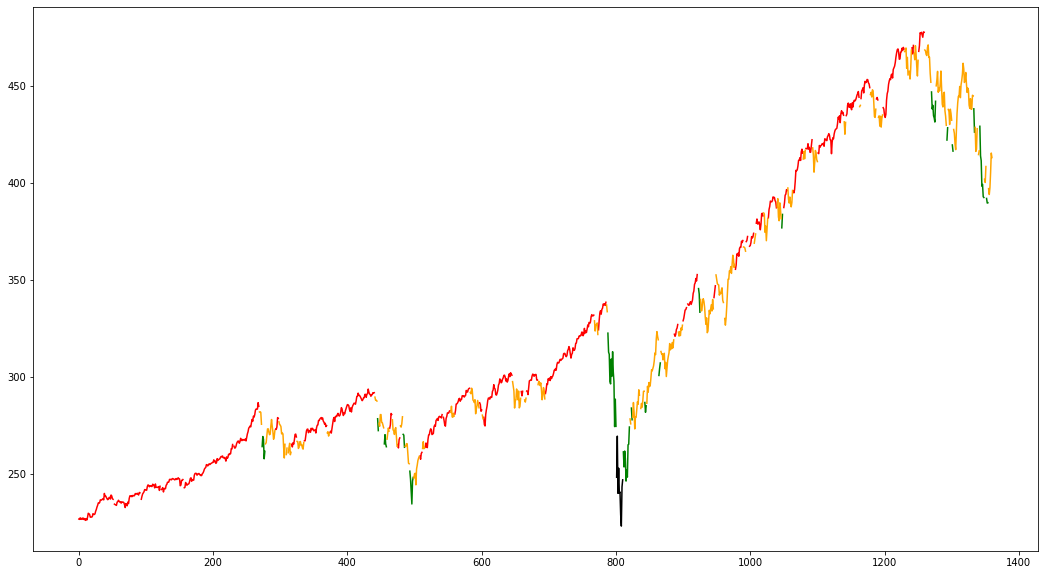

1361


In [10]:
# Plot chart
fig = plt.figure(figsize = (18,10))
plt.plot(labels_0, color="red")
plt.plot(labels_1, color="green")
plt.plot(labels_2, color="black")
plt.plot(labels_3, color="orange")
plt.show()
print(len(labels_0))

In [11]:
# Create the class
class StrategyManager():

    # Initialize the class
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    # Extract data
    def _extract_data(self, symbol, start_date, end_date):
        import yfinance as yf
        data = yf.download(symbol, start=start_date, end=end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        return data

    # Calculates general period returns and volatility
    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df["Bench_C_Rets"], sharpe = self._calculate_returns(df, True)
        self.sharpe = sharpe
        df.dropna(inplace=True)
        return df

    # Adjusts the signal to represent our strategy
    def _set_multiplier(self, direction):
        if direction == "long":
            pos_multiplier = 1
            neg_multiplier = 0
        elif direction == "long_short":
            pos_multiplier = 1
            neg_multiplier = -1
        else:
            pos_multiplier = 0
            neg_multiplier = -1
        return pos_multiplier, neg_multiplier

    # Calculates returns for equity curve
    def _calculate_returns(self, df, is_benchmark):
        
        # Calculate multiplier
        if not is_benchmark:
            multiplier_1 = df["Signal"].shift(1)
            multiplier_2 = 1 if "PSignal" not in df.columns else df["PSignal"].shift(1)
            
            # Assume open price on following day to avoid lookahead bias for close calculation
            log_rets = np.log(df["Open"].shift(-1) / df["Open"]) * multiplier_1 * multiplier_2
        else:            
            log_rets = np.log(df["Close"] / df["Close"].shift(1))
        
        # Calculate Sharpe Ratio
        sharpe_ratio = self.sharpe_ratio(log_rets)
        
        # Calculate Cumulative Returns
        c_log_rets = log_rets.cumsum()
        c_log_rets_exp = np.exp(c_log_rets) - 1
        
        # Return result and Sharpe ratio
        return c_log_rets_exp, sharpe_ratio
    
    def sharpe_ratio(self, return_series):
        N = 255 # Trading days in the year (change to 365 for crypto)
        rf = 0.005 # Half a percent risk free rare
        mean = return_series.mean() * N -rf
        sigma = return_series.std() * np.sqrt(N)
        sharpe = round(mean / sigma, 3)
        return sharpe

    # Replace Dataframe
    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

    # Moving average crossover strategy
    def backtest_ma_crossover(self, period_1, period_2, direction, drop_cols=[]):
        
        # Set df
        df = self.df
        
        # Get multipliers
        pos_multiplier, neg_multiplier = self._set_multiplier(direction)
            
        # Calculate Moving Averages
        if f"MA_{period_1}" or f"MA_{period_2}" not in df.columns:
            df[f"MA_{period_1}"] = df["Close"].rolling(window=period_1).mean()
            df[f"MA_{period_2}"] = df["Close"].rolling(window=period_2).mean()
            df.dropna(inplace=True)
        
        # Calculate Benchmark Returns
        df["Bench_C_Rets"], sharpe_ratio_bench = self._calculate_returns(df, True)
        
        # Calculate Signal
        df.loc[df[f"MA_{period_1}"] > df[f"MA_{period_2}"], "Signal"] = pos_multiplier
        df.loc[df[f"MA_{period_1}"] <= df[f"MA_{period_2}"], "Signal"] = neg_multiplier
        
        # Calculate Strategy Returns
        df["Strat_C_Rets"], sharpe_ratio_strat = self._calculate_returns(df, False)
        
        # Get values for output
        bench_rets = df["Bench_C_Rets"].values.astype(float)
        strat_rets = df["Strat_C_Rets"].values.astype(float)
        print("Sense check: ", round(df["Close"].values[-1] / df["Close"].values[0] - 1, 3), round(bench_rets[-1], 3))
        
        # Remove irrelevant features
        if len(drop_cols) > 0:
            df = df.drop(columns=drop_cols)
        
        # Ensure Latest DF matches
        df = df.dropna()
        self.df = df
        
        # Return df
        return df, sharpe_ratio_bench, sharpe_ratio_strat

**Base Strategy**

In [12]:
# Create an instance
strat_mgr = StrategyManager(symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [13]:
# Extract the modified data
df_strat_mgr = strat_mgr.df
df_strat_mgr.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2022-05-24,392.559998,395.149994,386.959991,393.890015,91448800,-0.007634,0.021165,0.748757
2022-05-25,392.309998,399.450012,391.890015,397.369995,91472900,0.008835,0.019291,0.764207
2022-05-26,398.670013,407.040009,398.450012,405.309998,82168300,0.019981,0.021559,0.799458
2022-05-27,407.910004,415.380005,407.700012,415.260010,84768700,0.024549,0.018837,0.843633
2022-05-31,413.549988,416.459991,410.029999,412.929993,95937000,-0.005611,0.015682,0.833289


In [14]:
# Check MA Strategy performance
strat_df, sharpe_b, sharpe_s = strat_mgr.backtest_ma_crossover(12, 21, "long", drop_cols=["High", "Low", "Volume"])
strat_df

Sense check:  0.813 0.813


,Open,Close,Returns,Range,Bench_C_Rets,MA_12,MA_21,Signal,Strat_C_Rets
Date,,,,,,,,,
2017-02-03,228.820007,229.339996,0.006893,0.004771,0.006893,227.840001,227.347145,1.0,0.000218
2017-02-06,228.869995,228.929993,-0.001788,0.003457,0.005093,228.091667,227.467621,1.0,0.002447
2017-02-07,229.380005,228.940002,0.000044,0.004110,0.005137,228.275000,227.550002,1.0,0.000524
2017-02-08,228.940002,229.240005,0.001310,0.004730,0.006454,228.532501,227.682382,1.0,0.001835
2017-02-09,229.240005,230.600006,0.005933,0.007459,0.012425,228.782501,227.879525,1.0,0.009527
...,...,...,...,...,...,...,...,...,...
2022-05-23,392.829987,396.920013,0.018710,0.018828,0.742635,397.640834,407.005239,0.0,0.240105
2022-05-24,392.559998,393.890015,-0.007634,0.021165,0.729332,396.186668,405.356668,0.0,0.240105
2022-05-25,392.309998,397.369995,0.008835,0.019291,0.744611,396.120000,404.464762,0.0,0.240105


Sharpe Ratio Base Strategy Benchmark:  0.548
Sharpe Ratio Base Strategy:  0.303


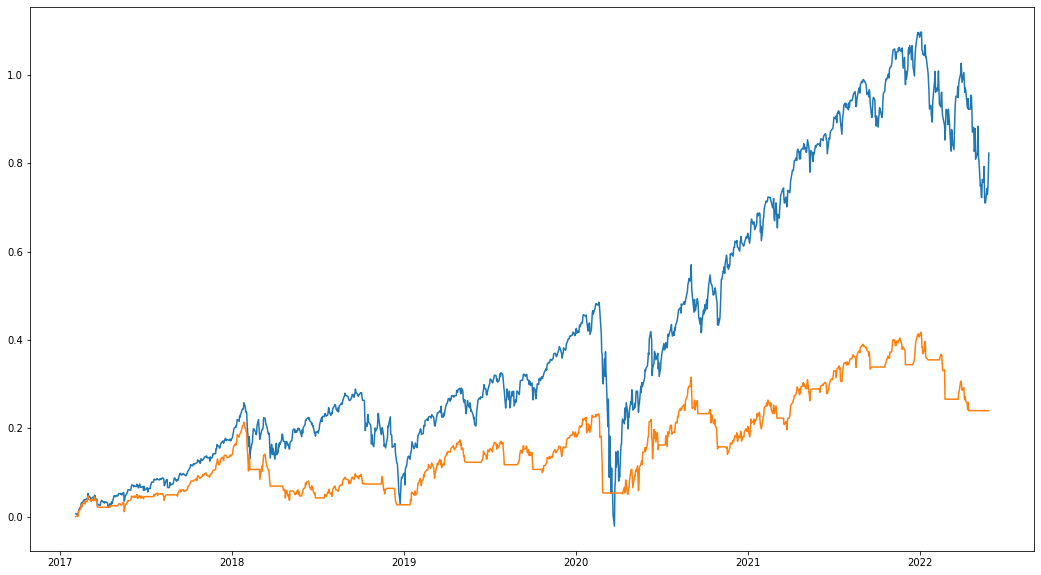

In [15]:
# Review equity curve and metrics
print("Sharpe Ratio Base Strategy Benchmark: ", sharpe_b)
print("Sharpe Ratio Base Strategy: ", sharpe_s)

fig = plt.figure(figsize = (18,10))
plt.plot(strat_df["Bench_C_Rets"])
plt.plot(strat_df["Strat_C_Rets"])
plt.show()

**Base Strategy Plus Market Regimes**

In [16]:
# Structure Data
X_train_2 = strat_df[["Returns", "Range"]].iloc[:500] # Train Test Split here
X_test = strat_df[["Returns", "Range"]].iloc[500:]
X_train_2.head()
df_strat_mgr_test = strat_df.copy()
len(X_train_2)

500

In [17]:
# Fit Model
hmm_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=100).fit(X_train_2)
print("Model Score:", hmm_model.score(X_train_2))

Model Score: 3681.773340386748


In [18]:
# Predict Market Regimes
hidden_states_preds = hmm_model.predict(X_test.values)
hidden_states_preds[:10]
len(hidden_states_preds)

839

In [19]:
# Set Favourable States - !!!!!!!!! ADJUST BASED ON HMM RESULTS AND TEST OUTCOME !!!!!!!!!!!!!!!!!!!!
favourable_states = [1, 2]

In [20]:
# Write Strategy
state_signals = []
for s in hidden_states_preds:
    if s in favourable_states:
        state_signals.append(1)
    else:
        state_signals.append(0)
print("States: ", state_signals[:10])
print("Lengh of States: ", len(state_signals))

States:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Lengh of States:  839


In [21]:
# Replace Strategy Dataframe
df_strat_mgr_test = df_strat_mgr_test.tail(len(X_test))
df_strat_mgr_test["PSignal"] = state_signals
strat_mgr.change_df(df_strat_mgr_test)
strat_mgr.df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Open,Close,Returns,Range,Bench_C_Rets,MA_12,MA_21,Signal,Strat_C_Rets,PSignal
Date,,,,,,,,,,
2019-01-31,267.510010,269.929993,0.008782,0.011973,0.185099,264.252497,260.104284,1.0,0.076129,0
2019-02-01,270.149994,270.059998,0.000482,0.007504,0.185670,265.061663,261.050951,1.0,0.075970,0
2019-02-04,270.109985,271.959991,0.007035,0.009912,0.194011,265.976662,262.372379,1.0,0.085252,0
2019-02-05,272.440002,273.100006,0.004192,0.005738,0.199017,266.821663,263.358570,1.0,0.086646,0
2019-02-06,272.790009,272.739990,-0.001318,0.005222,0.197436,267.344996,264.232855,1.0,0.079276,0


In [22]:
strat_df_2, sharpe_b_2, sharpe_s_2 = strat_mgr.backtest_ma_crossover(12, 21, "long")
strat_df_2

Sense check:  0.481 0.481


,Open,Close,Returns,Range,Bench_C_Rets,MA_12,MA_21,Signal,Strat_C_Rets,PSignal
Date,,,,,,,,,,
2019-03-04,281.600006,279.399994,-0.003637,0.018169,-0.003637,278.425837,275.680478,1.0,0.000000,1
2019-03-05,279.540009,279.019989,-0.001360,0.004849,-0.004993,278.812503,276.107144,1.0,-0.001395,0
2019-03-06,279.149994,277.329987,-0.006057,0.007907,-0.011019,278.809168,276.362858,1.0,-0.001395,0
2019-03-07,276.829987,275.010010,-0.008365,0.010654,-0.019293,278.572502,276.453811,1.0,-0.001395,1
2019-03-08,272.940002,274.459991,-0.002000,0.008186,-0.021254,278.243334,276.535716,1.0,0.007093,0
...,...,...,...,...,...,...,...,...,...,...
2022-05-20,393.250000,389.630005,0.000437,0.043333,0.389451,399.048332,408.391905,0.0,-0.067168,1
2022-05-23,392.829987,396.920013,0.018710,0.018828,0.415448,397.640834,407.005239,0.0,-0.067168,1
2022-05-24,392.559998,393.890015,-0.007634,0.021165,0.404643,396.186668,405.356668,0.0,-0.067168,1


Sharpe Ratio Benchmark:  0.513
Sharpe Ratio Regime Strategy with MA Cross:  -0.259
--- ---
Returns Benchmark: 44.54%
Returns Regime Strategy with MA Cross: -6.72%


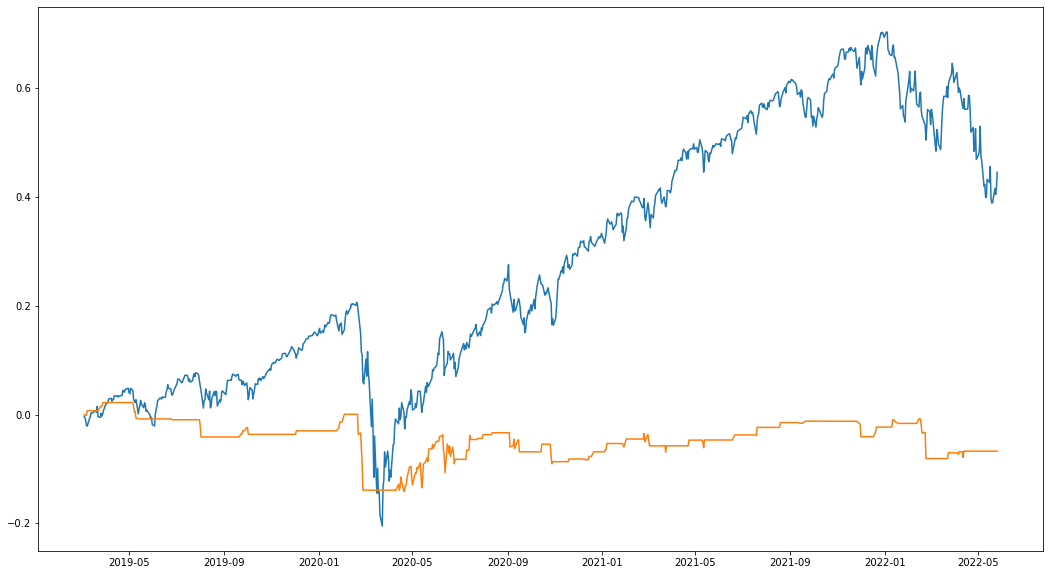

In [23]:
# Review equity curve
print("Sharpe Ratio Benchmark: ", sharpe_b_2)
print("Sharpe Ratio Regime Strategy with MA Cross: ", sharpe_s_2)
print("--- ---")
print(f"Returns Benchmark: {round(strat_df_2['Bench_C_Rets'].values[-1] * 100, 2)}%")
print(f"Returns Regime Strategy with MA Cross: {round(strat_df_2['Strat_C_Rets'].values[-1] * 100, 2)}%")

fig = plt.figure(figsize = (18, 10))
plt.plot(strat_df_2["Bench_C_Rets"])
plt.plot(strat_df_2["Strat_C_Rets"])
plt.show()

**RESOURCES**

https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader/